# Spectral Clustering Implementation and Appliacation 
### Qi Wang and Hanqiu Xia









## Abstract

Spectral clustering is widely used in image segmentation. The main idea of spectral clustering is to use the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction and then perform clustering in fewer dimensions.  In this project, we investigated the normalized spectral decomposition algorithm from the paper "On Spectral Clustering: Analysis and an algorithm" by A. Ng, M. Jordan, and Y. Weiss [1]. Their algorithm improved upon the existing spectral clustering algorithm by resolving the issues of inconsistent algorithms of using eigenvectors as well as providing evidence for a reasonable clustering. We implemented the algorithm using Python with considering both idea and special cases. We also optimized the Python codes by applying vectorization, Cython, Just-In-Time compiling and parallelization. Finally, we tested the algorithm on simulated and real datasets and compare the experimental results with those of k-means clustering to see if spectral clustering dramatically improves the results.

## 1.  Background

The research paper we chose is "On Spectral Clustering: Analysis and an algorithm" by A. Ng, M. Jordan, and Y. Weiss [1]. Spectral clustering is inspired by the the idea of spectral graph partitioning, in which we use the first two eigenvectors of a similarity matrix derived from the distance between points to partition the graph into exactly two parts. It is widely used in image segmentation. However, in previous literatures, authors are inconsistent in choosing and deriving eigenvectors. One of the achievement of A. Ng, M. Jordan, and Y. Weiss's paper is standardizing and simplifying the algorithem of spectral clustering[1]: utilising the  first $k$ largest eigenvectors to cluster points into  $k$ subsets. The detailed algorithm is as follows:

Suppose we have a set of $n$ points $S = \{ s_1, \ldots, s_n\}$ in ${\rm I\!R}^{m}$, and we want to cluster them into $k$ groups.

 **Step 1:** Construct the affinity matrix $A \in{\rm I\!R}^{n\times n} $,  each element in A is defined as $A_{ij} = exp(-||s_i-s_j||^2/2\sigma^2)$ and $A_{ii}=0$,  for $i, j = 1,\ldots, n$. 

**Step 2:** Define $D$ to be the diagonal matrix with $D_{ii} =\sum_{j=1}^{n} A _{ij}$, and form the normalized Laplacian matrix $L = D^{-1/2}AD^{-1/2}$.

**Step 3:** Capture the fist $k$ largest eigenvectors of $L, x_1, x_2,  \ldots, x_k, x_i \in {\rm I\!R}^{n} $ and form the matrix $X = [x_1 ~x_2 ~\cdots ~x_k ] \in  {\rm I\!R}^{n\times k}.$

**Step 4:** Create the new normalized matrix $Y \in {\rm I\!R}^{n\times k}$ from $X$, defined as $Y_{ij}= X_{ij}/(\sum_{j=1}^{n}X_{ij}^2)^{1/2}$.

** Step 5:** Consider $Y$ to be a set of $n$   points that need to be clustered now, apply K-means or any other algorithm that can minimize distortion to cluster $Y$. 

** Step 6:**  Assign the original point $s_i$ in to cluster $j$ if and only if the $i$th-row of $Y$ was distributed to cluster $j$  in previous step.       


Comparing to the straighforward K-means clustering, this algorithm improves the performance by normalizing affinity matrix $A$ and $X$. Especially for dataset in two-dimensional that are not correpsonding to convex region (like circular graph and moon-like graph), spectral clustering results in more reasonable clustering than K-means. We will implement this experiment in later parts.  This report is organized as follows: In part 2, we implement the spectral clustering algorithm on both simple and complex cases. Next, we practice the unit test and optimize coding in part 3 and 4, respectively.  Part 5 applies the algorithm in real and simulated datasets and compare the results with k-means clustering. Part 6 draws some conclusions.




## 2. Implementation
We have written four functions to implement the algorithm. The first function GenerateData generates data for the ideal case. The second function CalculateAffinity calculates the affinity matrix which is the first step in the above described algorithm. The third function Spectral implements Step 2 to 4 in the algorithm and creates a normalized matrix.
### 2.1 Simple Case

The ideal case denotes the situation when the clusters are clearly partitioned and are far apart from each other. The proposed mechanism works very well in this case and will result in an exact match to the true clustering of the original data.
### 2.1 Complex Case

In [232]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import time

import pandas as pd
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


import pandas as pd

In [190]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

### Simulate Simple Case Data
- Original Function

In [233]:
def GenerateData(select, CL1=7, CL2=14, CL3=21, seed=None):
    """Class methods are similar to regular functions.

       

        Args:
            param1: The first parameter.
            param2: The second parameter.

        Returns:
            True if successful, False otherwise.

    """
    if seed:
        random.seed(100)
    if select == 1:
        data = np.zeros((CL2,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        data = np.zeros((CL3,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2,CL3):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

- Using Vectorized 

In [192]:
def GenerateData_vectorized(s, c1=7, c2=14, c3=21, seed=None):
    if seed: 
        np.random.seed(seed)
    if s==1:
        x = 1 + np.random.random((c2, 2))
        x[c1:,:] += 2
    elif s==2:
        x = 1 + np.random.random((c3,2))
        x[c1:c2, 0] += 2
        x[c2:, 0] += 0.5
        x[c2:,1] += 2
    return x

- Using JIT

In [199]:
import numba
from numba import jit

In [200]:
@jit
def GenerateData_jit(select, CL1=7, CL2=14, CL3=21, seed=None):
    if seed:
        random.seed(100)
    if select == 1:
        data = np.zeros((CL2,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        data = np.zeros((CL3,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2,CL3):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

- Vectorized JIT

In [201]:
@jit
def GenerateData_vectorized_jit(s, c1=7, c2=14, c3=21, seed=None):
    if seed: 
        np.random.seed(seed)
    if s==1:
        x = 1 + np.random.random((c2, 2))
        x[c1:,:] += 2
    elif s==2:
        x = 1 + np.random.random((c3,2))
        x[c1:c2, 0] += 2
        x[c2:, 0] += 0.5
        x[c2:,1] += 2
    return x

- Using Cython

In [193]:
%load_ext cython

In [194]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_cython(select, CL1=7, CL2=14, CL3=21, seed=None):
    if seed:
        random.seed(100)
    if select == 1:
        data = np.zeros((CL2,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        data = np.zeros((CL3,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2,CL3):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

- Vectorized Cython

In [195]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_vectorized_cython(s, c1=7, c2=14, c3=21, seed=None):
    if seed: 
        np.random.seed(seed)
    if s==1:
        x = 1 + np.random.random((c2, 2))
        x[c1:,:] += 2
    elif s==2:
        x = 1 + np.random.random((c3,2))
        x[c1:c2, 0] += 2
        x[c2:, 0] += 0.5
        x[c2:,1] += 2
    return x

#### Speed-up ratio (Generate Data)

In [197]:
select = 2
report([GenerateData,GenerateData_vectorized],select)

GenerateData: 1.0
GenerateData_vectorized: 0.5


In [227]:
select = 2
report([GenerateData,GenerateData_jit],select)

GenerateData: 1.0
GenerateData_jit: 2.6


In [206]:
select = 2
report([GenerateData,GenerateData_vectorized_jit],select)

GenerateData: 1.0
GenerateData_vectorized_jit: 0.4


In [228]:
select = 2
report([GenerateData,GenerateData_cython],select)

GenerateData: 1.0
GenerateData_cython: 2.0


In [213]:
select = 2
report([GenerateData,GenerateData_vectorized_cython],select)

GenerateData: 1.0
GenerateData_vectorized_cython: 0.4


### Calculate Affinity
- Original Function

In [230]:
def CalculateAffinity(data,num_neighbours=5):
    sigma = 0.5
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    A = ( np.ones(affinity.shape) - np.eye(affinity.shape[0])) * affinity
    
    return A

- Using Vectorized

In [231]:
def eucli_dist(u,v):
    return np.sqrt(np.sum((u-v)**2))

def CalculateAffinity_vectorized(data):
    distance = euclidean_distances(data, data)
    sig = 0.5
    similarity = np.exp(-distance/(2*sig**2))
    
    return similarity
    

- Using JIT

In [234]:
@jit
def CalculateAffinity_jit(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


- Vectorized JIT

In [235]:
@jit
def eucli_vectorized_dist(u,v):
    return np.sqrt(np.sum((u-v)**2))
def CalculateAffinity_vectorized_jit(data):
    sigma = 1
    row,col = data.shape
    return np.array([[math.exp(-eucli_vectorized_dist(data[u,:],data[v,:])/(2*sigma**2)) 
                                                        for u in range(row)] 
                                                        for v in range(row)])

- Using Cython

In [236]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_cython(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

- Vectorized Cython

In [237]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def eucli_vectorized_dist(u,v):
    return np.sqrt(np.sum((u-v)**2))
def CalculateAffinity_vectorized_cython(data):
    sigma = 1
    row,col = data.shape
    return np.array([[math.exp(-eucli_vectorized_dist(data[u,:],data[v,:])/(2*sigma**2)) 
                                                        for u in range(row)] 
                                                        for v in range(row)])


#### Speed-up Ratio (Calculate Affinity )

In [238]:
data = GenerateData(2)

In [239]:
report([CalculateAffinity,CalculateAffinity_vectorized],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized: 0.3


In [241]:
report([CalculateAffinity,CalculateAffinity_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_jit: 75.8


In [243]:
report([CalculateAffinity,CalculateAffinity_vectorized_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_jit: 0.3


In [246]:
report([CalculateAffinity,CalculateAffinity_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_cython: 1.2


In [247]:
report([CalculateAffinity,CalculateAffinity_vectorized_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_cython: 0.3


### Spectral Clustering
- Original Function 

In [273]:
def Spectral(k, affinity):
  
    # compute the degree matrix
    #D =  np.zeros((affinity.shape))
    #for i in range(affinity.shape[0]):
        #D[i,i] = sum(affinity[i,:])
    D = np.diag(np.sum(affinity, axis=0))


    #compute the normalized laplacian / affinity matrix
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(U)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using JIT

In [284]:
@jit
def Spectral_jit(k,affinity):
  
    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


    #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 

  
    # apply K-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(U)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using Cython

In [285]:
%%cython -a

import cython
import numpy as np
import random
import math
import scipy.linalg as la
from sklearn.cluster import KMeans

@cython.boundscheck(False)
@cython.wraparound(False)


def Spectral_cython(k,affinity):
  
    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


    #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 
    # apply K-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(U)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

#### Speed-up Ratio (Spectral Clustering)

In [286]:
k = 3
data = GenerateData(2)
affinity = CalculateAffinity(data)

In [287]:
report([Spectral,Spectral_cython],k,affinity)

Spectral: 1.0
Spectral_cython: 1.8


In [291]:
report([Spectral,Spectral_jit],k,affinity)

Spectral: 1.0
Spectral_jit: 1.3


### Implementation (Ideal Case)

In [271]:
data = GenerateData(2)
affinity = CalculateAffinity(data)

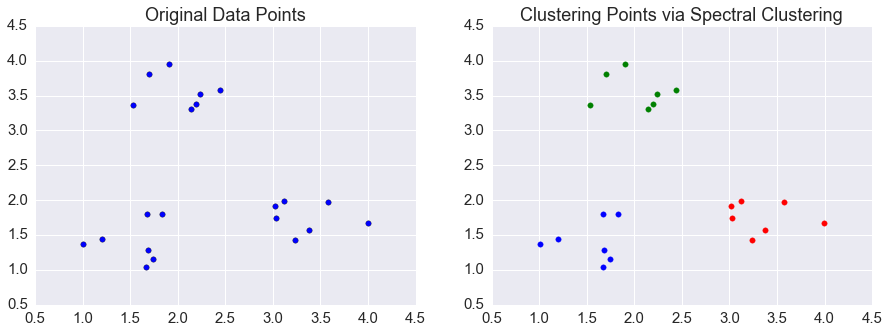

In [278]:
IDX= Spectral(3,affinity)

# Draw graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Spectral Clustering')
plt.show()




### Compare with K-Means (Idea Case)

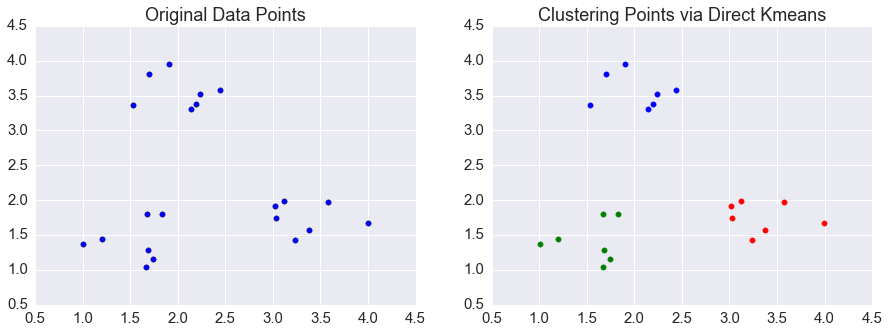

In [280]:
k=3
X=data

# Apply K-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()




### Simulate Convex Region data 
- Original Function

In [283]:
def CreateCircle(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

In [297]:
@jit
def CreateCircle_jit(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

In [293]:
%%cython -a

import cython
import numpy as np
import random


@cython.boundscheck(False)
@cython.wraparound(False)

def CreateCircle_cython(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df


#### Speed-up Ratio( Create Circular Data )

In [295]:
data = CreateCircle(3)
affinity = CalculateAffinity(data)
n = 3

In [300]:
report([CreateCircle,CreateCircle_jit],n)

CreateCircle: 1.0
CreateCircle_jit: 1.7


In [304]:
report([CreateCircle,CreateCircle_cython],n)

CreateCircle: 1.0
CreateCircle_cython: 0.2


### Implementation (Special Case)

In [307]:
k=3
data = CreateCircle(3)
affinity = CalculateAffinity(data)

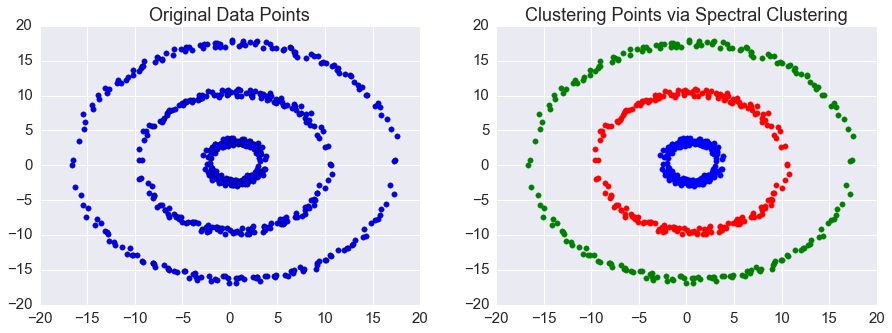

In [306]:
IDX= Spectral(k,affinity)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Spectral Clustering')
plt.show()



### Compare with K-means (Special Case)

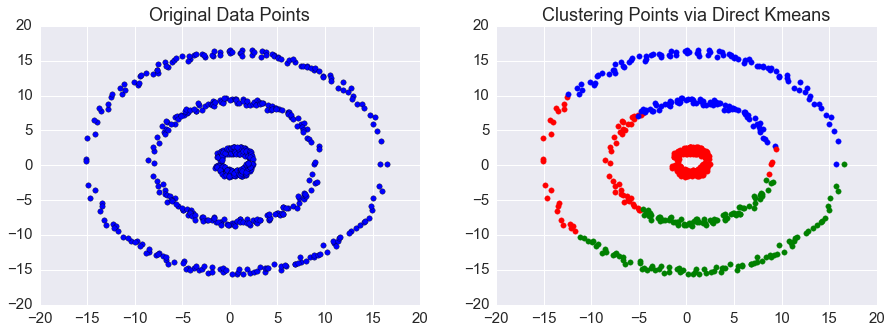

In [309]:
X=CreateCircle(3)

# Apply K-means directly
clust_result = KMeans(n_clusters=3, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()



### Implementation on Real Dataset 

In [316]:
a = np.loadtxt('jain.txt')

In [313]:
data = a[:,0:2]
affinity = CalculateAffinity(data)
k = 2

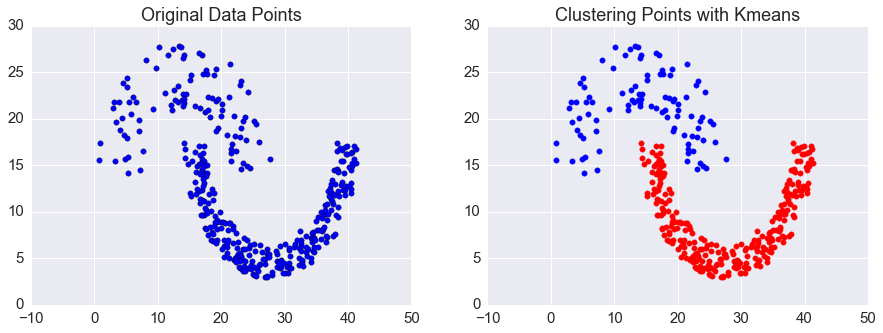

In [314]:
IDX=Spectral(k,affinity)

# Draw graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
#     elif IDX[i] == 2:
#         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points with Kmeans')
plt.show()

### Compare with K-means

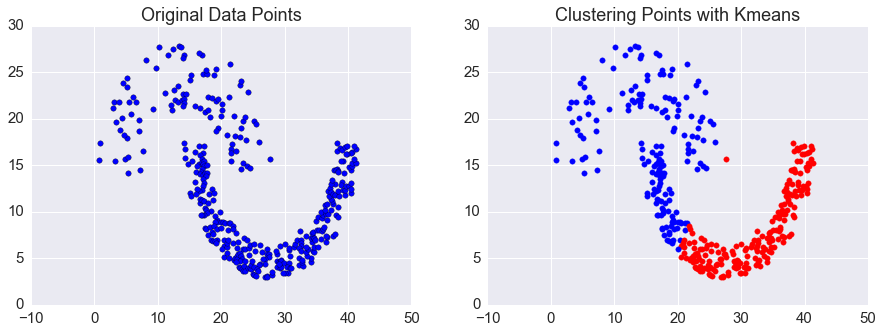

In [315]:
# Apply k-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
#     elif IDX[i] == 2:
#         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()